# Creating local estimates of boundary of basin of attraction

## Model a dynamical system

We model the Lorenz system, which consists of the following three ODEs: 

$$x'=\sigma(y-x) \\
y'=rx-y-xz \\
z'=xy-\beta z$$

In [3]:
import numpy as np
import math
from scipy.integrate import solve_ivp

We set some parameters and do a test simulation to observe the convergence process to a stable equilibrium. The simulation code is referenced from https://github.com/scipython/scipython-maths/blob/master/lorenz/lorenz.py

In [4]:
# Lorenz parameters and initial conditions.
sigma, beta, r = 10, 2.667, 10
x0, y0, z0 = 0, 1, 1.05

# Maximum time point and total number of time points.
tmax, n = 5000, 100000

In [5]:
def lorenz(t, X, sigma, beta, r):
    """The Lorenz equations."""
    x, y, z = X
    xp = sigma*(y - x)
    yp = r*x - y - x*z
    zp = -beta*z + x*y
    return xp, yp, zp

In [6]:
# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(sigma, beta, r),dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

After numerically solving the problem, we plot the trajectory.

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [9]:
WIDTH, HEIGHT, DPI = 1000, 750, 100

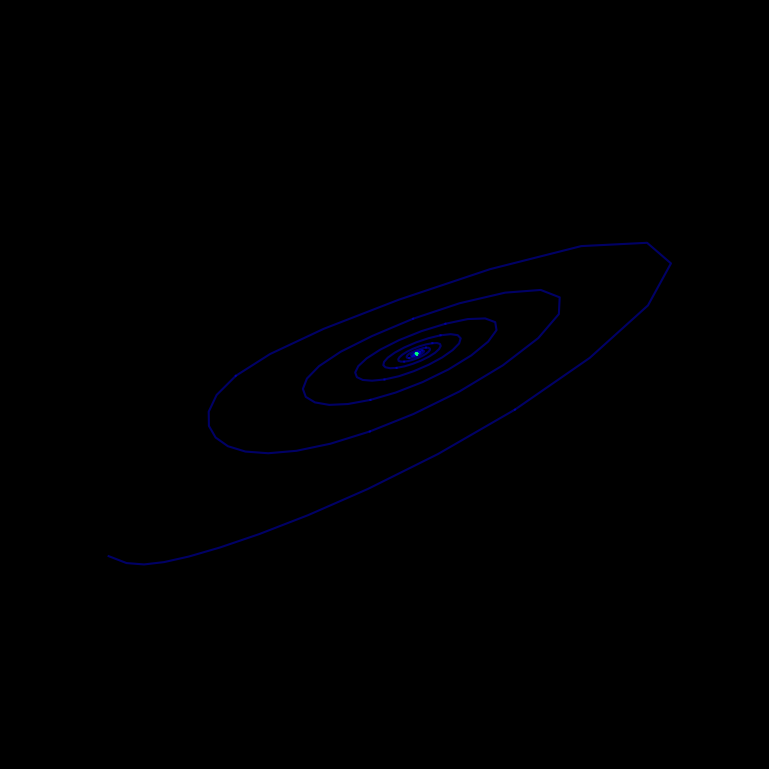

In [10]:
# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)

# Remove all the axis clutter, leaving just the curve.
ax.set_axis_off()

plt.savefig('lorenz_win.png', dpi=DPI)
plt.show()

By the setting of parameters, the system has two stable equilibriums. 

By checking the trace of the trajectory, we could observe that the flow converges to one of them.

## Simulation to collect data

We now form a dataset for training and testing with the following way: We randomly select initial conditions $(x_{0},y_{0},z_{0}) \in (-50,50)\times (-50,50) \times (-50,50)$ and compute the trajectories. We fix a stable equilibrium of interest, and label the points as 1 or -1 depending on whether the trajectory converges to that equilibrium. With the above set of parameters, we have that $(\sqrt{24}, \sqrt{24}, 9)$ is a stable equilibrium. We therefore obtain a dataset by simulating the trajectory of 500 sample points. If the trajectory is attracted, we label it as +1, otherwise -1.

In [20]:
# Check if the trajectory is attracted to the concerned Lorenz attractor
def is_attracted(x, y, z):
    return (abs(x-math.sqrt(24))<0.01) and (abs(y-math.sqrt(24))<0.01) and (abs(z-9)<0.01)

In [21]:
## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0 ,z0):
    tmax, n = 1500, 100000
    soln = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(sigma, beta, r),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y, z = soln.sol(t)
    return is_attracted(x[n-1], y[n-1], z[n-1])

In [22]:
def generate_random_points():
    x0 = np.random.uniform(-50, 50)
    y0 = np.random.uniform(-50, 50)
    z0 = np.random.uniform(-50, 50)
    return x0, y0, z0

In [23]:
import pandas as pd

# Create the dataset
df = pd.DataFrame(columns=['x0', 'y0', 'z0', 'attracted'])
for i in range(2000):
    x0, y0, z0 = generate_random_points()
    attracted_result = simulation(x0, y0, z0)
    attracted_result = 1 if attracted_result else -1  # map True to 1 and False to -1
    df.loc[i] = [x0, y0, z0, attracted_result]
    if i % 10 == 0:  # print progress every 10 iterations
        print(f"Progress: {i}/2000")

# Save the DataFrame to a CSV file
df.to_csv('dataset.csv', index=False)

Progress: 0/2000
Progress: 10/2000
Progress: 20/2000
Progress: 30/2000
Progress: 40/2000
Progress: 50/2000
Progress: 60/2000
Progress: 70/2000
Progress: 80/2000
Progress: 90/2000
Progress: 100/2000
Progress: 110/2000
Progress: 120/2000
Progress: 130/2000
Progress: 140/2000
Progress: 150/2000
Progress: 160/2000
Progress: 170/2000
Progress: 180/2000
Progress: 190/2000
Progress: 200/2000
Progress: 210/2000
Progress: 220/2000
Progress: 230/2000
Progress: 240/2000
Progress: 250/2000
Progress: 260/2000
Progress: 270/2000
Progress: 280/2000
Progress: 290/2000
Progress: 300/2000
Progress: 310/2000
Progress: 320/2000
Progress: 330/2000
Progress: 340/2000
Progress: 350/2000
Progress: 360/2000
Progress: 370/2000
Progress: 380/2000
Progress: 390/2000
Progress: 400/2000
Progress: 410/2000
Progress: 420/2000
Progress: 430/2000
Progress: 440/2000
Progress: 450/2000
Progress: 460/2000
Progress: 470/2000
Progress: 480/2000
Progress: 490/2000
Progress: 500/2000
Progress: 510/2000
Progress: 520/2000
Prog

## Reproduction of Shena et.al approach using deep neural network

With dataset generated, we will train a neural network to perform logistic regression by minimizing cross-entropy loss.

In [66]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [67]:
## Load the dataset
class LorenzDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor([self.data.iloc[idx].x0, self.data.iloc[idx].y0, self.data.iloc[idx].z0]).float()
        label = torch.tensor(self.data.iloc[idx].attracted).float()
        return features, label
    
dataset = LorenzDataset('dataset.csv')

dataset_train, dataset_test = torch.utils.data.random_split(dataset, [1600, 400])

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [68]:
features, labels = next(iter(dataloader_train))
print(features, labels)

tensor([[ 36.2786, -24.5941, -27.3658],
        [-20.3180,  37.1506, -29.8056],
        [-10.9317,  22.9209,  31.2063],
        [-24.3828,   6.4474,  22.5603],
        [-21.0678, -40.0645,  21.6001],
        [-22.9370, -44.5283, -31.9101],
        [ -7.1641, -37.2073,   0.1352],
        [ -2.0762, -27.6732,   7.3590],
        [ 20.1489,  22.7024,  43.3460],
        [-39.3973, -37.5965, -39.3426],
        [ 46.8130,  43.9758,  25.9445],
        [-36.3721, -48.0972, -43.6604],
        [-19.8652,  44.3419,  47.2030],
        [-30.8131, -47.0202,   0.4375],
        [-30.5644, -48.2114, -46.4989],
        [ -3.2884, -48.7013,   1.7047],
        [-40.3359,  -9.2556, -18.0339],
        [ -2.8712, -42.2718,   1.1253],
        [ -5.9712,  40.6517,  20.0890],
        [-48.2169, -47.0338, -15.2044],
        [-26.8655,  37.8699, -31.5992],
        [ 25.7358, -10.0302,  -0.8294],
        [ -2.6172,  -2.6368,  -9.7763],
        [  9.0355, -47.2583, -36.0013],
        [ -9.3798, -33.1837,  15.7173],


In [69]:
## Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
net = Net()

In [70]:
## Set up loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [75]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
net = net.to(device)

## Train the network
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    mini_batch_count = 0
    for features, labels in dataset_train:
        # Ensure features is a Tensor
        if not isinstance(features, torch.Tensor):
            features = torch.Tensor(features)

        # Ensure labels is a Tensor
        if not isinstance(labels, torch.Tensor):
            labels = torch.Tensor(labels)

        # Convert labels from -1 or 1 to 0 or 1
        labels = ((labels + 1) / 2).float()

        # Reshape labels to match the output shape
        labels = labels.view(-1)

        # Move the features and labels to the device
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        mini_batch_count += 1
        if mini_batch_count % 10 == 0:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, mini_batch_count, running_loss / 10))
            running_loss = 0.0
    print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / len(dataset_train)))

[1,    10] loss: 2.561
[1,    20] loss: 0.438
[1,    30] loss: 0.607
[1,    40] loss: 0.927
[1,    50] loss: 1.146
[1,    60] loss: 1.092
[1,    70] loss: 0.843
[1,    80] loss: 1.031
[1,    90] loss: 0.584
[1,   100] loss: 0.479
[1,   110] loss: 0.583
[1,   120] loss: 0.755
[1,   130] loss: 0.346
[1,   140] loss: 1.437
[1,   150] loss: 0.757
[1,   160] loss: 1.133
[1,   170] loss: 0.890
[1,   180] loss: 0.827
[1,   190] loss: 1.124
[1,   200] loss: 0.854
[1,   210] loss: 0.745
[1,   220] loss: 1.116
[1,   230] loss: 0.789
[1,   240] loss: 0.771
[1,   250] loss: 0.710
[1,   260] loss: 0.732
[1,   270] loss: 0.620
[1,   280] loss: 0.733
[1,   290] loss: 1.072
[1,   300] loss: 0.745
[1,   310] loss: 0.788
[1,   320] loss: 0.649
[1,   330] loss: 0.685
[1,   340] loss: 0.717
[1,   350] loss: 0.658
[1,   360] loss: 0.719
[1,   370] loss: 0.758
[1,   380] loss: 0.891
[1,   390] loss: 0.736
[1,   400] loss: 1.301
[1,   410] loss: 0.730
[1,   420] loss: 0.728
[1,   430] loss: 1.126
[1,   440] 

In [78]:
## Test the network
from torchmetrics import Accuracy

acc = Accuracy(task = 'binary')

net.eval()

dataloader_test = DataLoader(dataset_test, batch_size=20, shuffle=True)

with torch.no_grad():
    for features, labels in dataloader_test:
        features = features.to(device)
        labels = labels.to(device)
        # Convert labels from -1 or 1 to 0 or 1
        labels = ((labels + 1) / 2).float()
        outputs = (net(features) >= 0.5).float()
        outputs = outputs.squeeze()  # remove dimension of size 1
        acc.update(outputs, labels)
        
accuracy = acc.compute()
print(f"Accuracy: {accuracy}")

Accuracy: 0.7049999833106995
